In [2]:
# Loading libraries
import sys
sys.path.append("..")
from jnk3_noask1.model_analysis.jnk3_no_ask1 import model
import numpy as np
from pysb.simulator import ScipyOdeSimulator
import matplotlib.pyplot as plt
from jnk3_noask1.model_analysis.equilibration_function import pre_equilibration

/Users/dionisio/anaconda/envs/nicole/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Loading fitted parameters

idx_pars_calibrate = [1, 15, 17, 19, 24, 25, 26, 27]
rates_of_interest_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]

fitted_pars = np.load('../jnk3_noask1/model_analysis/pydream_most_likely_par.npy')
param_values = np.array([p.value for p in model.parameters])

par_set_calibrated = np.copy(param_values)
par_set_calibrated[rates_of_interest_mask] = 10 ** fitted_pars


In [4]:
# Generating parameter with different initial conditions
# for arrestin

n_conditions = 100
max_arrestin = 40
arrestin_initials = np.linspace(0, max_arrestin, n_conditions)
par_clus1 = par_set_calibrated

repeated_parameter_values = np.tile(par_clus1, (n_conditions, 1))
repeated_parameter_values[:, 32] = arrestin_initials
np.save('arrestin_diff_IC_par0.npy', repeated_parameter_values)

time_eq = np.linspace(0, 30, 30)
pars_ic_eq = np.copy(repeated_parameter_values)
pars_ic_eq[:, [24, 25]] = 0  # Setting catalytic reactions to zero for pre-equilibration
eq_conc = pre_equilibration(model, time_eq, pars_ic_eq)[1]

tspan = np.linspace(0, 10, 100)

sim1 = ScipyOdeSimulator(model=model, tspan=tspan).run(param_values=repeated_parameter_values, initials=eq_conc).all


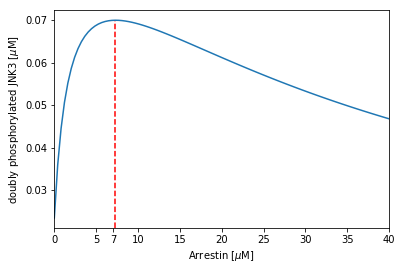

In [5]:
# plotting results

ppjnk3 = np.array([s['all_jnk3'][-1] for s in sim1])
ppjnk3_max_idx = np.argmax(ppjnk3)

plt.plot(arrestin_initials, ppjnk3)
plt.axvline(arrestin_initials[ppjnk3_max_idx], color='r', linestyle = 'dashed', ymax=0.95)
locs, labels = plt.xticks()
locs = np.append(locs, arrestin_initials[ppjnk3_max_idx])
plt.xticks(locs.astype(int))
plt.xlim(0, max_arrestin)
plt.xlabel(r'Arrestin [$\mu$M]')
plt.ylabel(r'doubly phosphorylated JNK3 [$\mu$M]')

# plt.savefig('plot_varying_arrestin_pars_pso_1h_test.pdf', format='pdf')
plt.show()